# Creating a useful dataset with removal of unwanted columns

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline

# LOADING THE DATASET

In [5]:
df_ign = pd.read_csv('ign.csv')
df_ign.head()

,Unnamed: 0,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


In [6]:
df_ign.shape

(18625, 11)

In [7]:
df_ign.score_phrase.value_counts()

Great          4773
Good           4741
Okay           2945
Mediocre       1959
Amazing        1804
Bad            1269
Awful           664
Painful         340
Unbearable       72
Masterpiece      55
Disaster          3
Name: score_phrase, dtype: int64

In [8]:
df_ign.score_phrase.value_counts(normalize=True)

Great          0.256268
Good           0.254550
Okay           0.158121
Mediocre       0.105181
Amazing        0.096859
Bad            0.068134
Awful          0.035651
Painful        0.018255
Unbearable     0.003866
Masterpiece    0.002953
Disaster       0.000161
Name: score_phrase, dtype: float64

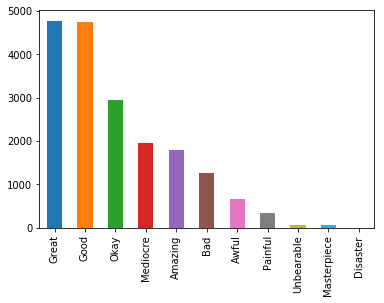

In [9]:
df_ign.score_phrase.value_counts().plot(kind='bar')

**Disaster is too small of impact to even count. Hence we better remove**

In [10]:
df_ign = df_ign[df_ign['score_phrase'] != 'Disaster']

In [11]:
df_ign.score_phrase.value_counts()

Great          4773
Good           4741
Okay           2945
Mediocre       1959
Amazing        1804
Bad            1269
Awful           664
Painful         340
Unbearable       72
Masterpiece      55
Name: score_phrase, dtype: int64

# Data Peprocessing

### a)-Convert score_phrase to binary sentiments and add a new column called sentiment

In [12]:
negative_mean_phases=['Bad', 'Awful', 'Painful', 'Unbearable']

In [13]:
df_ign['sentiment'] = df_ign.score_phrase.isin(negative_mean_phases).map({True: 'Negative', False: 'Positive'})

In [14]:
df_ign.sentiment[:5]

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

### b)-Positive Sentiments VS No. of Negative Seniments

In [15]:
df_ign.sentiment.value_counts()

Positive    16277
Negative     2345
Name: sentiment, dtype: int64

In [16]:
df_ign.sentiment.value_counts(normalize=True)

Positive    0.874074
Negative    0.125926
Name: sentiment, dtype: float64

### c)-checking null values

In [17]:
df_ign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18622 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        18622 non-null int64
score_phrase      18622 non-null object
title             18622 non-null object
url               18622 non-null object
platform          18622 non-null object
score             18622 non-null float64
genre             18586 non-null object
editors_choice    18622 non-null object
release_year      18622 non-null int64
release_month     18622 non-null int64
release_day       18622 non-null int64
sentiment         18622 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.8+ MB


genre             18586 non-null object

In [18]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [19]:
missing_values = find_missing_values(df_ign, columns=df_ign.columns)
missing_values

Number of missing or NaN values for each column:


{'Unnamed: 0': 0,
 'score_phrase': 0,
 'title': 0,
 'url': 0,
 'platform': 0,
 'score': 0,
 'genre': 36,
 'editors_choice': 0,
 'release_year': 0,
 'release_month': 0,
 'release_day': 0,
 'sentiment': 0}

### d)-Filling missing values

In [20]:
df_ign.fillna(value='', inplace=True)

In [21]:
df_ign.isnull().sum()

Unnamed: 0        0
score_phrase      0
title             0
url               0
platform          0
score             0
genre             0
editors_choice    0
release_year      0
release_month     0
release_day       0
sentiment         0
dtype: int64

In [22]:
df_ign[ df_ign['genre'] == '' ].shape

(36, 12)

### e)-checking duplicate values

In [23]:
df_ign.duplicated().sum()

0

# Create a new DataFrame for modeling

In [24]:
ign = df_ign[ ['sentiment', 'score_phrase', 'title', 'platform', 'genre', 'editors_choice'] ].copy()
ign.head(10)

,sentiment,score_phrase,title,platform,genre,editors_choice
0,Positive,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,Platformer,Y
1,Positive,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,Platformer,Y
2,Positive,Great,Splice: Tree of Life,iPad,Puzzle,N
3,Positive,Great,NHL 13,Xbox 360,Sports,N
4,Positive,Great,NHL 13,PlayStation 3,Sports,N
5,Positive,Good,Total War Battles: Shogun,Macintosh,Strategy,N
6,Negative,Awful,Double Dragon: Neon,Xbox 360,Fighting,N
7,Positive,Amazing,Guild Wars 2,PC,RPG,Y
8,Negative,Awful,Double Dragon: Neon,PlayStation 3,Fighting,N
9,Positive,Good,Total War Battles: Shogun,PC,Strategy,N


In [25]:
ign['text']=ign['title']

In [26]:
ign.head()

,sentiment,score_phrase,title,platform,genre,editors_choice,text
0,Positive,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,Platformer,Y,LittleBigPlanet PS Vita
1,Positive,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,Platformer,Y,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Positive,Great,Splice: Tree of Life,iPad,Puzzle,N,Splice: Tree of Life
3,Positive,Great,NHL 13,Xbox 360,Sports,N,NHL 13
4,Positive,Great,NHL 13,PlayStation 3,Sports,N,NHL 13


In [27]:
ign["text"]=ign["text"].str.cat(ign['platform'], sep=',')

In [28]:
ign.head()

,sentiment,score_phrase,title,platform,genre,editors_choice,text
0,Positive,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,Platformer,Y,"LittleBigPlanet PS Vita,PlayStation Vita"
1,Positive,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,Platformer,Y,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Positive,Great,Splice: Tree of Life,iPad,Puzzle,N,"Splice: Tree of Life,iPad"
3,Positive,Great,NHL 13,Xbox 360,Sports,N,"NHL 13,Xbox 360"
4,Positive,Great,NHL 13,PlayStation 3,Sports,N,"NHL 13,PlayStation 3"


**in 0ne step**

In [29]:
ign['text'] = ign['title'].str.cat(ign['platform'], sep=' ').str.cat(ign['genre'], sep=' ').str.cat(ign['editors_choice'], sep=' ')

In [30]:
ign.head()

,sentiment,score_phrase,title,platform,genre,editors_choice,text
0,Positive,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,Platformer,Y,LittleBigPlanet PS Vita PlayStation Vita Platf...
1,Positive,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,Platformer,Y,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Positive,Great,Splice: Tree of Life,iPad,Puzzle,N,Splice: Tree of Life iPad Puzzle N
3,Positive,Great,NHL 13,Xbox 360,Sports,N,NHL 13 Xbox 360 Sports N
4,Positive,Great,NHL 13,PlayStation 3,Sports,N,NHL 13 PlayStation 3 Sports N


In [31]:
ign = ign[ ['score_phrase', 'text'] ].copy()
ign.head()

,score_phrase,text
0,Amazing,LittleBigPlanet PS Vita PlayStation Vita Platf...
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Great,Splice: Tree of Life iPad Puzzle N
3,Great,NHL 13 Xbox 360 Sports N
4,Great,NHL 13 PlayStation 3 Sports N


In [32]:
type(ign)

pandas.core.frame.DataFrame

In [33]:
ign.dtypes

score_phrase    object
text            object
dtype: object

In [34]:
import pickle

ign.to_pickle('ign_dataset.pkl')

In [35]:
df = pd.read_pickle('ign_dataset.pkl')
df.shape

(18622, 2)

In [36]:
df.head()

,score_phrase,text
0,Amazing,LittleBigPlanet PS Vita PlayStation Vita Platf...
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Great,Splice: Tree of Life iPad Puzzle N
3,Great,NHL 13 Xbox 360 Sports N
4,Great,NHL 13 PlayStation 3 Sports N
